In [1]:
import tensorflow as tf 

#Load the model

def load_model(model_path:str):
    return tf.keras.models.load_model(model_path)

non_adversarial_model_path = "weight/trained_cnn_v1.0_non_adversary_example/conf_weight.h5"
adversarial_model_path = "weight/trained_cnn_v1.9_adversary_example/conf_weight.h5"

adversary_model = load_model(adversarial_model_path)
non_adversary_model = load_model(non_adversarial_model_path)

In [10]:
adversary_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       409728    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                        

In [2]:
import numpy as np

non_adversarial_data = np.load('adversarial_example/raw/test_set.npz')
x_non_adversary, y_non_adversary = non_adversarial_data['x'], non_adversarial_data['y']

adversarial_data_1 = np.load('adversarial_example/generated/test_set.npz')
x_adversary_1, y_adversary_1 = adversarial_data_1['x'], adversarial_data_1['y']

adversarial_data_2 = np.load('adversarial_example/generated/test_set_with_original_label.npz')
x_adversary_2, y_adversary_2, true_y_adversary_2 = adversarial_data_2['x'], adversarial_data_2['y'], adversarial_data_2['y_true']



In [3]:
print("non adversarial shape : X: {}, Y:{}".format(x_non_adversary.shape, y_non_adversary.shape))
print("adversarial shape 1 : X: {}, Y:{}".format(x_adversary_1.shape, y_adversary_1.shape))
print("adversarial shape 2 : X: {}, Y:{}".format(x_adversary_2.shape, y_adversary_2.shape))

non adversarial shape : X: (547, 128, 128, 3), Y:(547,)
adversarial shape 1 : X: (2121, 128, 128, 3), Y:(2121,)
adversarial shape 2 : X: (2121, 128, 128, 3), Y:(2121,)


In [5]:
len(true_y_adversary_2)

2121

In [6]:
def evaluation(x, y, model):
    y_categorical = tf.keras.utils.to_categorical(y, num_classes=3)
    return model.evaluate(x=x, y=y_categorical)

# Non adversary dataset
# Non adversary model
non_adversary_model_normal_dataset = evaluation(
    x=x_non_adversary,
    y=y_non_adversary,
    model=non_adversary_model
)[1]

# adversary dataset
# Non adversary model
non_adversary_model_adversary_dataset = evaluation(
    x=x_adversary_2,
    y=true_y_adversary_2,
    model=non_adversary_model
)[1]


67/67 [==============================] - 0s 5ms/step - loss: 8.1661 - accuracy: 0.5677


In [7]:

def combine_dataset(x_adv, y_adv, x_non_adv):
    # Evaluate adversary data and non adversary for complete evaluation
    x_adversary_list, y_adversary_list = x_adv.tolist(), y_adv.tolist()
    x_non_adversary_list, y_non_adversary_list = x_non_adv.tolist(), np.zeros(len(x_non_adv))

    # Join all of the list the list
    all_x_adversary, all_y_adversary = [], []
    all_x_adversary.extend(x_adversary_list)
    all_y_adversary.extend(y_adversary_list)
    all_x_adversary.extend(x_non_adversary_list)
    all_y_adversary.extend(y_non_adversary_list)

    all_x_adversary = np.array(all_x_adversary)
    all_y_adversary = np.array(all_y_adversary)

    return all_x_adversary, all_y_adversary

all_x_adversary_1, all_y_adversary_1 = combine_dataset(x_adversary_1, y_adversary_1, x_non_adversary)
all_x_adversary_2, all_y_adversary_2 = combine_dataset(x_adversary_2, y_adversary_2, x_non_adversary)

In [9]:
# adversary dataset
# adversary model
adversary_model_adversary_dataset_1 = evaluation(
    x=all_x_adversary_1,
    y=all_y_adversary_1,
    model=adversary_model
)[1]

adversary_model_adversary_dataset_2 = evaluation(
    x=all_x_adversary_2,
    y=all_y_adversary_2,
    model=adversary_model
)[1]

84/84 [==============================] - 1s 6ms/step - loss: 5.5549 - accuracy: 0.6241


In [42]:
from sklearn.metrics import f1_score

def model_predict(model, x):
    prediction_result = model.predict(x)
   
    integer_predictions = []
    # Convert the prediction from confidence into integer label
    for predictions in prediction_result:
        integer_predictions.append(predictions.argmax())

    return integer_predictions

def get_f1_score(y_true, y_pred):
    result = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    print(result)

In [44]:
# Non adversary dataset
# Non adversary model
# Get prediction
print("F1-score for non-adversarial model and non-adversarial dataset")
y_pred_non_adversary_model_normal_dataset = model_predict(non_adversary_model, x_non_adversary)
get_f1_score(y_true=y_non_adversary, y_pred=y_pred_non_adversary_model_normal_dataset)

# adversary dataset
# Non adversary model
# Get prediction
print("F1-score for non-adversarial model and adversarial dataset")
y_pred_non_adversary_model_adv_dataset = model_predict(non_adversary_model, x_adversary_2)
get_f1_score(y_true=true_y_adversary_2, y_pred=y_pred_non_adversary_model_adv_dataset)

F1-scpre for non-adversarial model and non-adversarial dataset
18/18 [==============================] - 0s 14ms/step
0.9872029250457038
F1-scpre for non-adversarial model and adversarial dataset
67/67 [==============================] - 0s 4ms/step
0.5676567656765676


In [55]:
# adversary dataset
# adversary model
# Get prediction
print("F1-score for adversarial model and adversarial dataset 1")
y_pred_adversary_model_adv_dataset_1 = model_predict(adversary_model, all_x_adversary_1)
get_f1_score(y_true=all_y_adversary_1, y_pred=y_pred_adversary_model_adv_dataset_1)

# adversary dataset
# adversary model
# Get prediction
print("F1-score for adversarial model and adversarial dataset 2")
y_pred_adversary_model_adv_dataset_2 = model_predict(adversary_model, all_x_adversary_2)
get_f1_score(y_true=all_y_adversary_2, y_pred=y_pred_adversary_model_adv_dataset_2)

F1-score for adversarial model and adversarial dataset 1
84/84 [==============================] - 0s 6ms/step
0.802848575712144
F1-score for adversarial model and adversarial dataset 2
84/84 [==============================] - 0s 5ms/step
0.6240629685157422


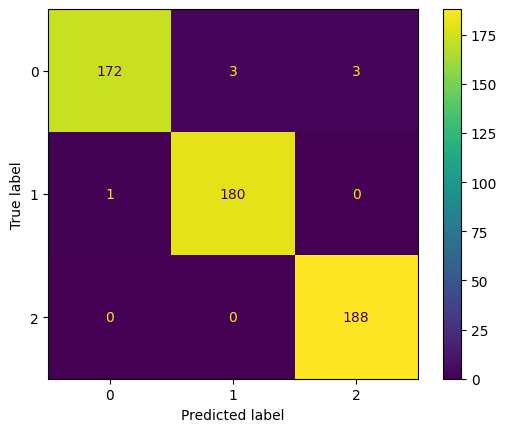

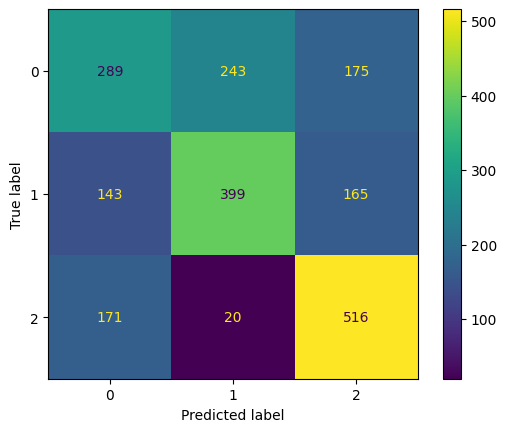

In [65]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

def display_confusion_matrix(y_true, y_pred, save_path):
    #fig=plt.gcf()
    container = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.show()
    container.figure_.savefig(save_path)
    #fig.savefig(save_path)

# Non adversary dataset
# Non adversary model
display_confusion_matrix(y_true=y_non_adversary, y_pred=y_pred_non_adversary_model_normal_dataset, save_path="evaluation/normal_model_normal_dataset.jpg")

# adversary dataset
# Non adversary model
display_confusion_matrix(y_true=true_y_adversary_2, y_pred=y_pred_non_adversary_model_adv_dataset, save_path="evaluation/normal_model_adv_dataset.jpg")

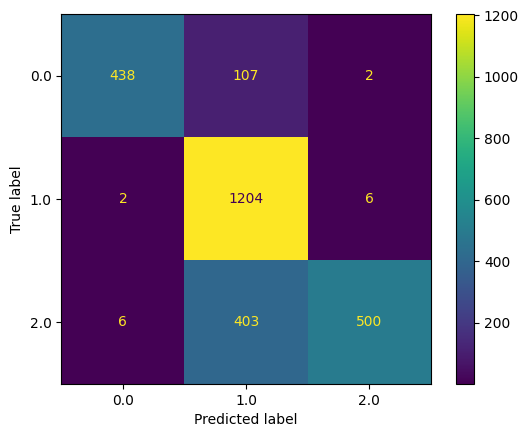

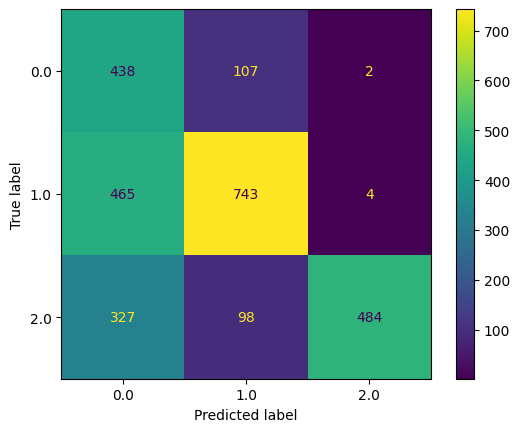

In [66]:
# adversary dataset
# adversary model
display_confusion_matrix(y_true=all_y_adversary_1, y_pred=y_pred_adversary_model_adv_dataset_1, save_path="evaluation/adv_model_normal_dataset1.jpg")

# adversary dataset
# adversary model
display_confusion_matrix(y_true=all_y_adversary_2, y_pred=y_pred_adversary_model_adv_dataset_2, save_path="evaluation/adv_model_normal_dataset2.jpg")